In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
housing = pd.read_csv("housing.csv")

In [4]:
#Read the data
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [7]:
#Function below converts bin values into discrete intervals
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
income_cat            20640 non-null category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [11]:
for set_ in (strat_test_set,strat_train_set):
    set_.drop("income_cat",axis=1,inplace=True)

In [12]:
housing = strat_train_set.copy()

In [13]:
#looking for correlations using Karl Pearson's method
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
#it seems like there is strong corelation between
#median_house_value and median_income

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

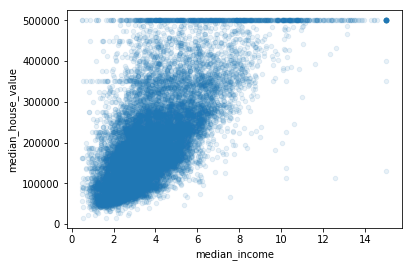

In [14]:
housing.plot(kind="Scatter",x="median_income",y="median_house_value",alpha=0.1)


In [15]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["populaton_per_room"] = housing["population"]/housing["households"]

In [16]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687160
rooms_per_household    0.146285
total_rooms            0.135097
housing_median_age     0.114110
households             0.064506
total_bedrooms         0.047689
populaton_per_room    -0.021985
population            -0.026920
longitude             -0.047432
latitude              -0.142724
bedrooms_per_room     -0.259984
Name: median_house_value, dtype: float64

In [17]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [18]:
housing_num = housing.drop("ocean_proximity",axis=1)

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
num_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])

num_attribute = list(housing_num)
cat_attr = ["ocean_proximity"]
full_pipeLine = ColumnTransformer([
    ("num",num_pipe,num_attribute),
    ("cat",OneHotEncoder(),cat_attr),
])

In [20]:
housing_prepared = full_pipeLine.fit_transform(housing)

In [21]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [22]:
#using Linear Regression Model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [23]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeLine.transform(some_data)
print("Predictions:",lin_reg.predict(some_data_prepared))
print("Labels:",list(some_labels))

Predictions: [211574.39523833 321345.10513719 210947.519838    61921.01197837
 192362.32961119]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [24]:
#training using decision tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)


DecisionTreeRegressor()

In [25]:
#Using Decision Tree on full training Data set give us 0.0 
#error but is it valid? we have to do cross validation
#because our model might have overfitting issue
from sklearn.metrics import mean_squared_error
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [26]:
#Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_score = np.sqrt(-scores)

scores2 = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_score = np.sqrt(-scores2)

In [27]:
def display_scores(value):
    print("Scores: ",value)
    print("Mean: ",value.mean())
    print("Standard Deviation",value.std())

In [28]:
#As we did the cross validation we figure out that Decision Tree 
#performed worse than the Linerar model
display_scores(tree_rmse_score)
display_scores(lin_rmse_score)

Scores:  [66617.93931011 66111.1463848  72329.04760858 69328.95571362
 68495.96405088 76790.3116037  65771.34322496 70725.35297046
 69782.83153573 70329.53583281]
Mean:  69628.2428235662
Standard Deviation 3130.305624647394
Scores:  [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
Mean:  69223.18594556303
Standard Deviation 2657.268311277697


In [29]:
#Linear model undefits our training data and Decision Tree overfits our data
#and cannot perform well in predictions

In [30]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
forest_housing_prediction = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels,forest_housing_prediction)
f_rmse = np.sqrt(forest_rmse)

In [31]:
print(f_rmse)

18403.364262922547


In [32]:
socres3 = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
forest_score= np.sqrt(-socres3)
display_scores(forest_score)

Scores:  [47596.45921548 46163.53620484 49067.02873461 50315.47410217
 48875.66303719 53207.20119617 48879.56233419 50241.74853073
 51495.86978898 49285.12077648]
Mean:  49512.76639208318
Standard Deviation 1862.9071614626773


In [41]:
#This is better score than the other two methods
#Building a model on top of another model is called Ensemble Learning
from sklearn.model_selection import GridSearchCV
param_grid = [{
    'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]
forest_reg= RandomForestRegressor()
gird_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)


In [42]:
gird_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
gird_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [ ]:
final_model = gird_search.best_estimator_